In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import datetime as dt
import math as mt

In [2]:
def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = dataframe_y_true[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    pred = dataframe_y_pred[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*5.55
    test = dataframe_y_true[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    pred = dataframe_y_pred[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*49.79
    test = dataframe_y_true[~dataframe_y_true['TV'].isna()]['TV']
    pred = dataframe_y_pred[~dataframe_y_true['TV'].isna()]['TV']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*14.57
    test = dataframe_y_true[~dataframe_y_true['kettle'].isna()]['kettle']
    pred = dataframe_y_pred[~dataframe_y_true['kettle'].isna()]['kettle']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*4.95
    score /= 74.86
    return score

In [3]:
PATH = ''

### Load Data and Inspect

In [32]:
X_train = pd.read_csv(PATH+"X_train.csv")
X_train = X_train.drop(X_train.columns[-1],axis=1)
X_train.head(5)

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure
0,2013-03-17T00:01:00.0,550.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-03-17T00:02:00.0,548.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-17T00:03:00.0,549.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-03-17T00:04:00.0,549.3667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-03-17T00:05:00.0,548.8909,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
y_train = pd.read_csv(PATH+"y_train.csv")
y_train.head(5)

,time_step,washing_machine,fridge_freezer,TV,kettle
0,2013-03-17T00:01:00.0,0.0,79.2000,7.0,0.0
1,2013-03-17T00:02:00.0,0.0,78.0000,7.0,0.0
2,2013-03-17T00:03:00.0,0.0,76.9000,7.0,0.0
3,2013-03-17T00:04:00.0,0.0,76.1111,7.0,0.0
4,2013-03-17T00:05:00.0,0.0,75.2727,7.0,0.0


In [34]:
X_test = pd.read_csv(PATH+"X_test.csv")
X_test = X_test.drop(X_test.columns[-1],axis=1)
X_test.head(5)

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure
0,2014-01-01T00:00:00.0,312.2222,30.0,8.4,86.0,8.4,5.6,17.0,1016.6
1,2014-01-01T00:01:00.0,318.8750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-01T00:02:00.0,314.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-01T00:03:00.0,311.4444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-01T00:04:00.0,310.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
X_train = X_train.sort_values(by="time_step")
y_train = y_train.sort_values(by="time_step")

### Missing Value Imputation

In [36]:
sample1 = X_train.interpolate(method='linear')
sample1 = sample1.interpolate(method='linear', limit_direction='both')
sample1['consumption'] = X_train['consumption']
X_train_imputed = sample1.copy()
X_train_imputed.isna().sum()

time_step          0
consumption    10231
visibility         0
temperature        0
humidity           0
humidex            0
windchill          0
wind               0
pressure           0
dtype: int64

In [37]:
X_train_imputed_3min = X_train_imputed.interpolate(method='nearest', limit_direction='forward', limit=3)

In [38]:
sample2 = X_test.interpolate(method='linear')
sample2 = sample2.interpolate(method='linear', limit_direction='both')
sample2['consumption'] = X_test['consumption']
X_test_imputed = sample2.copy()

In [39]:
y_train_imputed_3min = y_train.interpolate(method='nearest', limit_direction='forward', limit=3)

In [40]:
X_train_A = X_train_imputed_3min.copy()
X_test_A = X_test_imputed.copy()
y_train_A = y_train_imputed_3min.copy()

### Data Integration

In [41]:
train = pd.merge(X_train_A, y_train_A,
                 how="left",
                 left_on=['time_step'],
                 right_on=['time_step'],
                 sort=False
                )

### Visualization

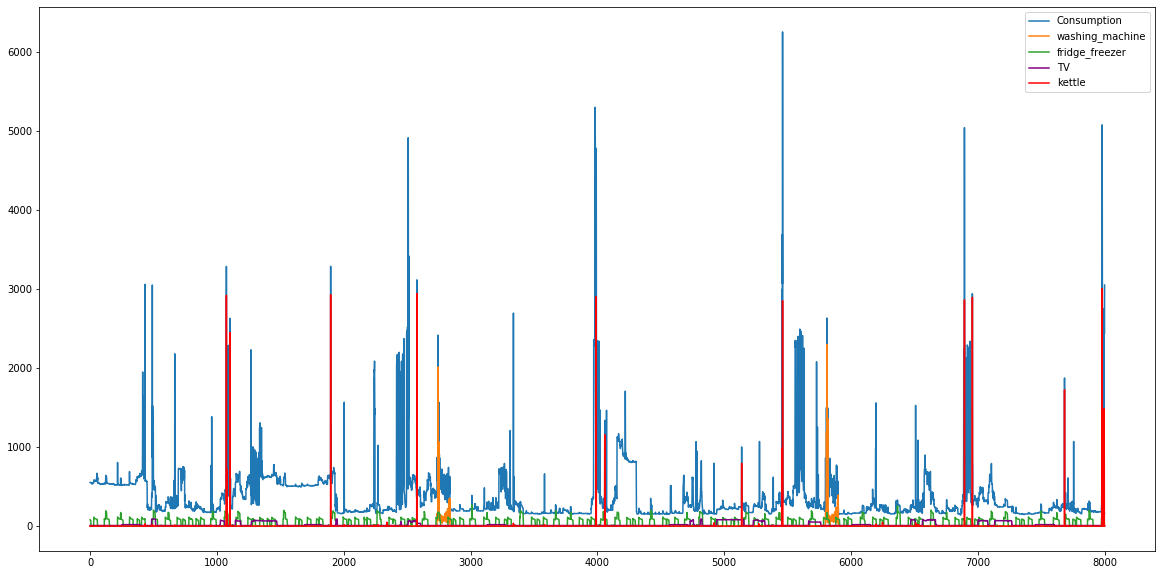

In [42]:
fig = plt.figure(figsize=(20,10))

size = 8000

plot_sample = train.iloc[:size,:]
plt.plot(np.arange(0,size,1), plot_sample['consumption'], label='Consumption')
plt.plot(np.arange(0,size,1), plot_sample['washing_machine'], label='washing_machine')
plt.plot(np.arange(0,size,1), plot_sample['fridge_freezer'], label='fridge_freezer')
plt.plot(np.arange(0,size,1), plot_sample['TV'], label='TV', color="purple")
plt.plot(np.arange(0,size,1), plot_sample['kettle'], label='kettle', color="red")

plt.legend()

plt.show()

In [43]:
train_notnull = train[train['consumption'].notna()]

### Feature Engineering

In [72]:
X_vars = ['consumption', 'visibility', 'temperature', 'humidity','humidex',
                   'windchill', 'wind', 'pressure']
y_vars = ['washing_machine','fridge_freezer','TV','kettle']

In [73]:
train_notnull['date'] = train_notnull['time_step'].str[:10]
train_notnull['hour'] = train_notnull['time_step'].str[11:13].astype('int')

train_notnull['date'] = pd.to_datetime(train_notnull['date'], infer_datetime_format=True)

train_notnull['dayofweek'] = train_notnull['date'].dt.dayofweek

In [55]:
isweekend = []
for day in list(train_notnull['dayofweek']):
    if day in [5,6]:
        isweekend.append(1)
    else:
        isweekend.append(0)
train_notnull['isweekend'] = isweekend

In [75]:
train_notnull = pd.concat([train_notnull, pd.get_dummies(train_notnull['dayofweek'], prefix='day'),
                           pd.get_dummies(train_notnull['hour'], prefix='hour')], axis=1)
train_notnull.columns

Index(['time_step', 'consumption', 'visibility', 'temperature', 'humidity',
       'humidex', 'windchill', 'wind', 'pressure', 'washing_machine',
       'fridge_freezer', 'TV', 'kettle', 'hour', 'dayofweek', 'isweekend',
       'date', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [82]:
train_notnull['hour_sin'] = np.sin((train_notnull['hour'] + 1) * 360. / 24. * np.pi / 180. )
train_notnull['hour_cos'] = np.cos((train_notnull['hour'] + 1) * 360. / 24. * np.pi / 180. )

In [87]:
### PCA of weather data
from sklearn.decomposition import PCA

PCA_features = ['visibility', 'temperature', 'humidity', 'humidex', 'windchill', 'wind', 'pressure']
PCA_data = train_notnull[PCA_features]

pca = PCA(n_components=3)
pca3_feature = pca.fit_transform(PCA_data)
print(pca.explained_variance_ratio_)

train_notnull['WeatherPCA1'] = pca3_feature[:,0]
train_notnull['WeatherPCA2'] = pca3_feature[:,1]
train_notnull['WeatherPCA3'] = pca3_feature[:,2]

[0.73707085 0.14668166 0.06543395]


In [89]:
train_notnull.columns

Index(['time_step', 'consumption', 'visibility', 'temperature', 'humidity',
       'humidex', 'windchill', 'wind', 'pressure', 'washing_machine',
       'fridge_freezer', 'TV', 'kettle', 'hour', 'dayofweek', 'isweekend',
       'date', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_sin',
       'hour_cos', 'WeatherPCA1', 'WeatherPCA2', 'WeatherPCA3'],
      dtype='object')

In [91]:
X_vars_base = ['consumption']
X_vars_day = ['isweekend', 'day_0', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
X_vars_hour1 = ['hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23']
X_vars_hour2 = ['hour_sin', 'hour_cos']
X_vars_weather1 = ['visibility', 'temperature', 'humidity',
                   'humidex', 'windchill', 'wind', 'pressure']
X_vars_weather2 = ['WeatherPCA1', 'WeatherPCA2', 'WeatherPCA3']

### Linear Model

In [92]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [137]:
X_vars_set = X_vars_base+X_vars_day+X_vars_hour2

In [138]:
X = train_notnull[['time_step']+X_vars_set]
y = train_notnull[y_vars]

In [139]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print('Train size: {train}, Test size: {test}'.format(train=x_train.shape[0], test=x_test.shape[0]))

Train size: 368649, Test size: 40961


In [140]:
x_train.columns

Index(['time_step', 'consumption', 'isweekend', 'day_0', 'day_1', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'hour_sin', 'hour_cos'],
      dtype='object')

In [141]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train[x_train.columns[1:]])
y_scaled = scaler.fit_transform(y_train)

In [142]:
len(y_scaled[:,0])

368649

1 - washing_machine; 2 - fridge_freezer; 3 - TV; 4 - kettle;

In [143]:
y_pred = x_test[['time_step']]

In [144]:
reg1 = LinearRegression().fit(x_scaled, y_scaled[:,0])
y_pred['washing_machine'] = reg1.predict(x_test[X_vars_set])

reg2 = LinearRegression().fit(x_scaled, y_scaled[:,1])
y_pred['fridge_freezer'] = reg2.predict(x_test[X_vars_set])

reg3 = LinearRegression().fit(x_scaled, y_scaled[:,2])
y_pred['TV'] = reg3.predict(x_test[X_vars_set])

reg4 = LinearRegression().fit(x_scaled, y_scaled[:,3])
y_pred['kettle'] = reg4.predict(x_test[X_vars_set])

In [145]:
metric_nilm(y_test, y_pred)

73.5590971290617

In [21]:
y_test = X_test_A[['time_step']]

In [22]:
X_test_B = X_test_A.fillna(0)

In [23]:
reg1 = LinearRegression().fit(X_scaled, y_scaled[:,0])
y_test['washing_machine'] = reg1.predict(X_test_B[X_vars])

reg2 = LinearRegression().fit(X_scaled, y_scaled[:,1])
y_test['fridge_freezer'] = reg2.predict(X_test_B[X_vars])

reg3 = LinearRegression().fit(X_scaled, y_scaled[:,2])
y_test['TV'] = reg3.predict(X_test_B[X_vars])

reg4 = LinearRegression().fit(X_scaled, y_scaled[:,3])
y_test['kettle'] = reg4.predict(X_test_B[X_vars])

In [24]:
y_test['washing_machine'].loc[X_test_A['consumption'].isnull()] = np.nan
y_test['fridge_freezer'].loc[X_test_A['consumption'].isnull()] = np.nan
y_test['TV'].loc[X_test_A['consumption'].isnull()] = np.nan
y_test['kettle'].loc[X_test_A['consumption'].isnull()] = np.nan

In [48]:
pd.get_dummies(train_notnull['dayofweek'], prefix='day_')

,day__0,day__1,day__2,day__3,day__4,day__5,day__6
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
5,0,0,0,0,0,0,1
6,0,0,0,0,0,0,1
7,0,0,0,0,0,0,1
8,0,0,0,0,0,0,1
9,0,0,0,0,0,0,1


In [57]:
# train_notnull1 = train_notnull1.drop(['date','dayofweek','hour'], axis=1)

### ELM / Hierarchical-ELMs (H-ELMs)

In [33]:
! pip install sklearn --upgrade
import sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=7ff64bcff4b45fbc795fc83905d2fde124c608444cda24d3fadfe514f7a2dbd1
  Stored in directory: /Users/FerdinandYu/Library/Caches/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn


In [60]:
from elm2 import ELMClassifier, ELMRegressor, GenELMClassifier, GenELMRegressor
from random_layer import RandomLayer, MLPRandomLayer, RBFRandomLayer, GRBFRandomLayer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import pipeline
from sklearn.linear_model import LinearRegression

In [62]:
X = train_notnull1[['time_step']+X_vars2]
y = train_notnull1[y_vars]

In [63]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Train size: {train}, Test size: {test}'.format(train=x_train.shape[0], test=x_test.shape[0]))

Train size: 327688, Test size: 81922


In [64]:
x_train = scaler.fit_transform(x_train[x_train.columns[1:]])
y_train = scaler.fit_transform(y_train)

In [65]:
x_test.head(5)

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,isweekend,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
91887,2013-05-19T19:28:00.0,264.2000,15.466667,18.053333,68.866667,20.366667,17.313333,20.600000,1004.393333,1,...,0,0,0,0,0,1,0,0,0,0
78286,2013-05-10T08:47:00.0,370.9000,5.111667,8.078333,99.000000,8.378333,5.543333,14.566667,995.173333,0,...,0,0,0,0,0,0,0,0,0,0
61727,2013-04-28T20:48:00.0,242.0000,12.000000,13.460000,80.200000,14.760000,13.020000,7.400000,1012.560000,1,...,0,0,0,0,0,0,1,0,0,0
92863,2013-05-20T11:44:00.0,200.2000,13.000000,13.386667,81.266667,14.766667,11.613333,19.000000,1008.420000,0,...,0,0,0,0,0,0,0,0,0,0
362187,2013-11-23T12:28:00.0,314.8889,47.666667,6.886667,81.400000,6.886667,6.573333,4.000000,1017.120000,1,...,0,0,0,0,0,0,0,0,0,0


In [66]:
y_pred = x_test[['time_step']]

In [70]:
elmr = ELMRegressor(random_state=0, n_hidden=512, activation_func='sigmoid', alpha=0.5)

elmr1 = elmr.fit(x_train, y_train[:,0])
y_pred['washing_machine'] = elmr1.predict(x_test[X_vars2])

elmr2 = elmr.fit(x_train, y_train[:,1])
y_pred['fridge_freezer'] = elmr2.predict(x_test[X_vars2])

elmr3 = elmr.fit(x_train, y_train[:,2])
y_pred['TV'] = elmr3.predict(x_test[X_vars2])

elmr4 = elmr.fit(x_train, y_train[:,3])
y_pred['kettle'] = elmr4.predict(x_test[X_vars2])

In [68]:
y_pred

,time_step,washing_machine,fridge_freezer,TV,kettle
91887,2013-05-19T19:28:00.0,0.129888,0.133018,-0.549154,0.359859
78286,2013-05-10T08:47:00.0,0.642314,0.296762,-0.316853,0.725199
61727,2013-04-28T20:48:00.0,0.129888,0.133018,-0.549154,0.359859
92863,2013-05-20T11:44:00.0,0.129888,0.133018,-0.549154,0.359859
362187,2013-11-23T12:28:00.0,0.271750,0.194151,-0.514240,0.502898
289070,2013-10-03T17:51:00.0,1.042140,0.708723,0.493876,1.336776
222744,2013-08-18T16:25:00.0,0.129888,0.133018,-0.549154,0.359859
183109,2013-07-22T03:50:00.0,0.129888,0.133018,-0.549154,0.359859
417423,2013-12-31T21:04:00.0,0.149350,0.141017,-0.544641,0.377997
110710,2013-06-01T21:11:00.0,0.310806,0.196355,-0.515073,0.486250


In [69]:
metric_nilm(y_test, y_pred)

64.37562333666634

In [ ]:
elmr = pipeline.Pipeline([('rhl', RandomLayer(random_state=0, n_hidden=2048, activation_func='sigmoid', alpha=0.5)),
                          ('lr', LinearRegression(fit_intercept=True))])

elmr1 = elmr.fit(x_train, y_train[:,0])
y_pred['washing_machine'] = elmr1.predict(x_test[X_vars2])

elmr2 = elmr.fit(x_train, y_train[:,1])
y_pred['fridge_freezer'] = elmr2.predict(x_test[X_vars2])

elmr3 = elmr.fit(x_train, y_train[:,2])
y_pred['TV'] = elmr3.predict(x_test[X_vars2])

elmr4 = elmr.fit(x_train, y_train[:,3])
y_pred['kettle'] = elmr4.predict(x_test[X_vars2])

In [93]:
metric_nilm(y_test, y_pred)

67.58354972011233